I want to sanity test that the mock measurements I'm comparing to are what I expect them to be, and the bad fits I'm recovering are because my models are a poor fit and not some other reason. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy as np
from os import path
from astropy.table import Table
from halotools.mock_observables import hod_from_mock
from halotools.utils import broadcast_host_halo_property, add_halo_hostid

from pearce.mocks.kittens import TrainingBox, MDPL2
import h5py

/home/users/swmclau2/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#cat_dir = '/u/ki/swmclau2/des'
cat_dir = '/home/users/swmclau2/scratch/UniverseMachine/'

In [4]:
um_catalog = Table(np.load(path.join(cat_dir, 'cut_um_catalog.npy')))

In [5]:
catalog_fname = '/home/users/swmclau2/scratch/test_MDPL2_halo_vpeak_smf_sham_large.hdf5'
halo_catalog = Table.read(catalog_fname, format = 'hdf5')#, path = 'halo_vpeak_shuffled'))

In [6]:
len(halo_catalog)

42615485

In [7]:
haloprop_bins = np.logspace(10,16, 61)
hbc = (haloprop_bins[1:] + haloprop_bins[:-1])/2.0

In [8]:
um_catalog['halo_mvir'] = um_catalog['m']
um_catalog['halo_id'] = um_catalog['id']
um_catalog['halo_upid'] = um_catalog['upid']
#um_catalog['halo_hostid'] = um_catalog['upid']
#um_catalog['halo_hostid']

In [9]:
from halotools.utils import broadcast_host_halo_property, add_halo_hostid
add_halo_hostid(um_catalog)
broadcast_host_halo_property(um_catalog, halo_property_key = 'halo_mvir')

In [10]:
um_hod, _ = hod_from_mock( um_catalog['halo_mvir_host_halo'],halo_catalog['halo_mvir'], haloprop_bins)

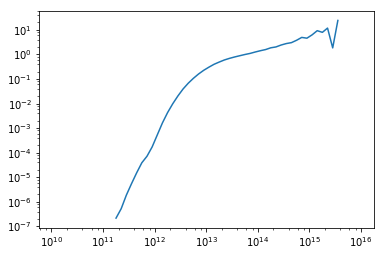

In [11]:
plt.plot(hbc, um_hod)

plt.loglog();

In [12]:
r_bins = np.logspace(-1, 1.6, 19)
rbc = (r_bins[1:]+r_bins[:-1])/2.0

In [13]:
um_wp = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/UMmock_wp.npy')
#shuffled_sham_wp = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/SHUFFLED_SHAMmock_wp.npy')
#nfw_sham_wp = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/NFWIZED_SHAMmock_wp.npy')

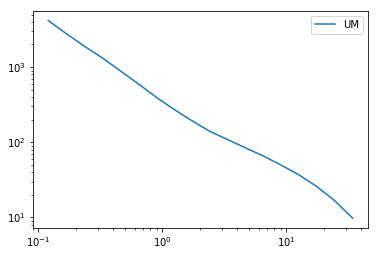

In [14]:
plt.plot(rbc, um_wp, label ='UM')
#plt.plot(rbc, shuffled_sham_wp, label = 'Shuffled')
#plt.plot(rbc, nfw_sham_wp, label = 'NFW')
plt.loglog();
plt.legend(loc='best')

In [15]:
um_ds = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/UMmock_ds.npy')

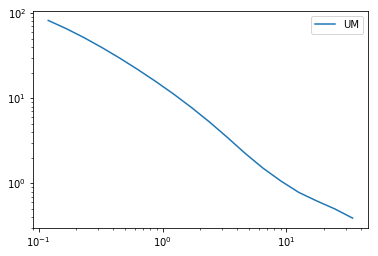

In [16]:
plt.plot(rbc, um_ds, label ='UM')
#plt.plot(rbc, shuffled_sham_ds, label = 'Shuffled')
#plt.plot(rbc, nfw_sham_ds, label = 'NFW')
plt.loglog();
plt.legend(loc='best')

In [17]:
mdpl2 = MDPL2()

In [18]:
cat = TrainingBox(0,system='ki-ls')
cat.load_model(1.0, HOD='abZheng07')

In [19]:
mdpl2.pmass

1510000000.0

In [20]:
mass_function = np.histogram(halo_catalog[halo_catalog['halo_upid']==-1]['halo_mvir'], haloprop_bins)[0]

In [21]:
mass_function[hbc<mdpl2.pmass*100] = 0.0

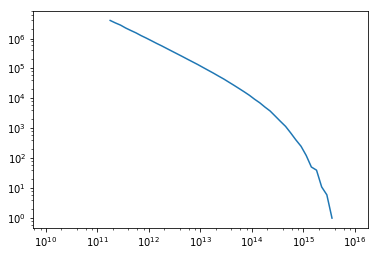

In [22]:
plt.plot(hbc, mass_function)
plt.loglog();

In [23]:
def calc_analytic_nd(cat, params, min_ptcl):
    hod = calc_hod(cat, params, hbc)
    return np.sum(mass_function * hod) / ((1000) ** 3)  # /self.h)**3)


In [24]:
from scipy.optimize import minimize_scalar, curve_fit
def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (calc_analytic_nd(cat,hod_params, min_ptcl=100) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12.0,14.0),\
                          args = (hod_params,), \
                          options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    hod_params['logMmin'] = res.x
    #print res.x,
    #print calc_analytic_nd(cat, hod_params, min_ptcl=100)


In [25]:
def calc_hod(cat, params, bin_centers):
    cat.model.param_dict.update(params)
    cens_occ, sats_occ = cat.model.model_dictionary['centrals_occupation'], cat.model.model_dictionary[
        'satellites_occupation']
    for key, val in params.iteritems():
        if key in cens_occ.param_dict:
            cens_occ.param_dict[key] = val
        if key in sats_occ.param_dict:
            sats_occ.param_dict[key] = val

    cen_hod = getattr(cens_occ, "baseline_mean_occupation", cens_occ.mean_occupation)(prim_haloprop=bin_centers)

    sat_hod = getattr(sats_occ, "baseline_mean_occupation", sats_occ.mean_occupation)(prim_haloprop=bin_centers)

    return cen_hod, sat_hod

In [26]:
cen_mask = um_catalog['halo_upid'] == -1
host_mask = halo_catalog['halo_upid'] == -1
cut_galcat = um_catalog[np.logical_and(cen_mask, um_catalog['halo_mvir_host_halo']>1e13)]
cut_halocat = halo_catalog[np.logical_and(host_mask, halo_catalog['halo_mvir'] > 1e13)]

In [27]:
#from collections import Counter
A = set(cut_galcat['halo_hostid'])
B = set(cut_halocat['halo_id'])

In [28]:
halo_catalog.colnames

['halo_upid',
 'halo_vacc',
 'halo_vmax',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_macc',
 'halo_halfmass_scale',
 'halo_y',
 'halo_id',
 'halo_x',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_vpeak',
 'halo_z',
 'halo_mvir',
 'halo_hostid',
 'halo_rvir',
 'halo_mvir_host_halo',
 'gal_smass']

In [29]:
B-A

{12647812673,
 12665225218,
 12683051011,
 12638486533,
 12577669126,
 12574689244,
 12675710990,
 12638486544,
 12585009173,
 12619612187,
 12630971738,
 12602310686,
 12668895265,
 12675711010,
 12698342747,
 12633243685,
 12587106342,
 12667845566,
 12571465052,
 12602310699,
 12638486575,
 12667060232,
 12633243698,
 12704546869,
 12655263799,
 12614893624,
 12619612218,
 12613289063,
 12704546878,
 12665942636,
 12675711043,
 12668728438,
 12682002503,
 12571250004,
 12613320778,
 12673613901,
 12688293966,
 12634292304,
 12614893649,
 12577669203,
 12682002518,
 12652554937,
 12602310744,
 12585009241,
 12604407900,
 12577669213,
 12637438048,
 12619350032,
 12587106402,
 12619612259,
 12638486631,
 12682002536,
 12602310761,
 12588679275,
 12704546935,
 12585009274,
 12599077567,
 12704022656,
 12633243779,
 12619612292,
 12638486661,
 12679905418,
 12585009292,
 12666361198,
 12675711129,
 12588679322,
 12619612315,
 12602310812,
 12673613981,
 12585009313,
 12659458210,
 12633

In [30]:
test_id = 12647812673
test_row = halo_catalog[np.where(test_id==halo_catalog['halo_id'])[0]] 
print test_id in um_catalog['halo_id']

False


In [31]:
test_row

halo_upid,halo_vacc,halo_vmax,halo_rs_klypin,halo_snapnum,halo_macc,halo_halfmass_scale,halo_y,halo_id,halo_x,halo_vx,halo_vy,halo_vz,halo_rs,halo_vpeak,halo_z,halo_mvir,halo_hostid,halo_rvir,halo_mvir_host_halo,gal_smass
int64,float32,float32,float32,int64,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float64
-1,0.5972,429.54,1322175.5,125,28.8951,7178000000000.0,533.9881,12647812673,598.974,-447.99,375.41,260.11,0.044769,16900000000000.0,545.04175,15132000000000.0,12647812673,0.52170706,15132000000000.0,11.652884869812798


In [32]:

sham_cen_hod, _ = hod_from_mock( um_catalog['halo_mvir_host_halo'][cen_mask],halo_catalog[host_mask]['halo_mvir'], haloprop_bins)
sham_sat_hod, _  = hod_from_mock( um_catalog['halo_mvir_host_halo'][~cen_mask],halo_catalog[host_mask]['halo_mvir'], haloprop_bins)

In [33]:
def cen_hod(hbc, sigma_logM, logMmin, full_range = False, log =False):
    params = {'sigma_logM': sigma_logM, 'logMmin': logMmin}
    cat.model.param_dict.update(params)
    
    cens_occ = cat.model.model_dictionary['centrals_occupation']
    
    for key, val in params.iteritems():
        if key in cens_occ.param_dict:
            cens_occ.param_dict[key] = val
            
    cen_hod = getattr(cens_occ, "baseline_mean_occupation", cens_occ.mean_occupation)(prim_haloprop=hbc)
    #sat_hod = getattr(sats_occ, "baseline_mean_occupation", sats_occ.mean_occupation)(prim_haloprop=bin_centers)

    if full_range:
        return cen_hod
    
    if log:
        return np.log10(cen_hod[15:-4])
    return cen_hod[15:-4]

In [34]:
def sat_hod(hbc, alpha, logM0, logM1, full_range = False):
    params = {'alpha': alpha, 'logM0': logM0, 'logM1': logM1}
    params.update( {'sigma_logM': t[0], 'logMmin': t[1]})
    cat.model.param_dict.update(params)
    sats_occ = cat.model.model_dictionary['satellites_occupation']
    cens_occ, sats_occ = cat.model.model_dictionary['centrals_occupation'], cat.model.model_dictionary[
        'satellites_occupation']
    for key, val in params.iteritems():
        if key in cens_occ.param_dict:
            cens_occ.param_dict[key] = val
        if key in sats_occ.param_dict:
            sats_occ.param_dict[key] = val
                
    sat_hod = getattr(sats_occ, "baseline_mean_occupation", sats_occ.mean_occupation)(prim_haloprop=hbc)

    if full_range:
        return sat_hod
    return sat_hod[:-4]

In [35]:
t = curve_fit(cen_hod, hbc, sham_cen_hod[15:-4], p0 = [0.1, 12.5])[0]
_t= curve_fit(lambda a,b,c: cen_hod(a,b,c, log=True), hbc, np.log10(sham_cen_hod[15:-4]), p0 = [0.5, 12.5])[0]
print t, _t


[ 1.10288026 13.37424141] [ 0.53397051 13.23727736]


In [36]:
min_halo_mass = cat.pmass*100

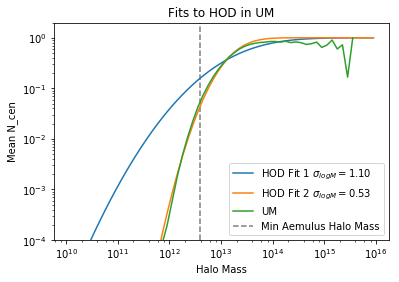

In [38]:
plt.plot(hbc, cen_hod(hbc, *t, full_range=True), label = r'HOD Fit 1 $\sigma_{logM} = %0.2f$'%t[0])
plt.plot(hbc, cen_hod(hbc, *_t, full_range=True), label = r'HOD Fit 2 $\sigma_{logM} = %0.2f$'%_t[0])
plt.vlines(min_halo_mass, 1e-4, 3, linestyles='dashed', alpha = 0.5, label = 'Min Aemulus Halo Mass')
#plt.plot(hbc, cen_hod(hbc, *[0.5, 13.421], full_range=True))
plt.plot(hbc, sham_cen_hod, label = 'UM')
plt.legend(loc='best')
plt.ylim([1e-4, 2])
plt.loglog();
plt.xlabel('Halo Mass')
plt.ylabel('Mean N_cen')
plt.title('Fits to HOD in UM')

In [39]:
t2 = curve_fit(sat_hod, hbc,sham_sat_hod[:-4], p0 = [0.9, 13.3, 14.5])[0]
print t2

[  1.01927556 -23.23414665  14.36848844]


/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


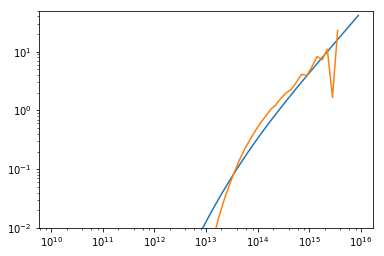

In [40]:
plt.plot(hbc, sat_hod(hbc, *t2, full_range=True))
plt.plot(hbc, sham_sat_hod)
plt.ylim([1e-2, 50])
plt.loglog();

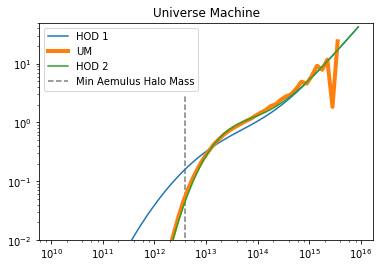

In [41]:
plt.plot(hbc, cen_hod(hbc, *t, full_range=True)*(1+sat_hod(hbc, *t2, full_range=True)), label = 'HOD 1')
plt.plot(hbc, sham_cen_hod+sham_sat_hod, label = 'UM', lw= 4)
plt.plot(hbc, cen_hod(hbc, *_t, full_range=True)*(1+sat_hod(hbc, *t2, full_range=True)), label = 'HOD 2')
plt.vlines(min_halo_mass, 1e-4, 3, linestyles='dashed', alpha = 0.5, label = 'Min Aemulus Halo Mass')

plt.ylim([1e-2, 50])
plt.legend(loc='best')
plt.loglog();
plt.title('Universe Machine')

In [ ]:
tf =['/home/users/swmclau2/scratch/Aemulators/wp_zheng07/PearceWpCosmo.hdf5',
    '/home/users/swmclau2/scratch/Aemulators/ds_zheng07/PearceDsCosmo.hdf5']

In [ ]:
from pearce.emulator import LemonPepperWet
emus = []
for tmp in tf:
    print tmp
    emus.append(LemonPepperWet(tmp, fixed_params = {'z':0.0}, hyperparams = {}) )

In [ ]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [ ]:
hod_pnames = ['sigma_logM', 'logM0', 'logM1', 'alpha', 'conc_gal_bias']#,\
              #'mean_occupation_centrals_assembias_param1',\
              #'mean_occupation_satellites_assembias_param1',
             #'mean_occupation_centrals_assembias_slope1',\
              #'mean_occupation_satellites_assembias_slope1']
hod_true_vals = [t[0], 12.5, t2[2], t2[0], 1.0]#, 0.0, 0.0, 1.0, 1.0]
#hod_true_vals = [0.2, 13.2, 14.5, 0.95, 1.0, 0.0, 0.0, 1.0, 1.0]

In [ ]:
hod_dict = dict(zip(hod_pnames, hod_true_vals))

In [ ]:
true_param_dict = cat_val_dict
true_param_dict.update(dict(zip(hod_pnames, hod_true_vals)))
#true_param_dict.update(zip(chain_pnames, chain.mean(axis=0)))

In [ ]:
emu_wp = emus[0].emulate_wrt_r(true_param_dict).squeeze()

In [ ]:
plt.plot(rbc, (10**emu_wp), label = 'Emu')
plt.plot(rbc, um_wp, label ='UM')

plt.loglog();
plt.legend(loc='best')

In [ ]:
plt.plot(rbc, (10**emu_wp)/um_wp, label = 'Emu')
plt.plot(rbc, um_wp/um_wp, label ='UM')

plt.xscale('log');
plt.legend(loc='best')

In [ ]:
emu_ds = emus[1].emulate_wrt_r(true_param_dict).squeeze()

In [ ]:
plt.plot(rbc, (10**emu_ds), label = 'Emu')
plt.plot(rbc, um_ds, label ='UM')
plt.loglog();
plt.legend(loc='best')

In [ ]:
plt.plot(rbc, (10**emu_ds)/um_ds, label = 'Emu')
plt.plot(rbc, um_ds/um_ds, label ='UM')
plt.xscale('log');
plt.legend(loc='best')

In [ ]:
from pearce.mocks.kittens import TrainingBox # load a smaller sim I cna handle in this notebook
# this may not have the same behavior at smaller masses though

In [ ]:
cat = TrainingBox(10, system='sherlock')

In [ ]:
cat.load(1.0, HOD='zheng07', system='sherlock')

In [ ]:
hod_dict['logMmin'] = t[1]
cat.populate(hod_dict, min_ptcl=100)

In [ ]:
wp_hod= cat.calc_wp(r_bins)

In [ ]:
cat.calc_analytic_nd()

In [ ]:
#hod_host_masses = cat.model.mock.halo_table['halo_mvir']
hod_host_masses = cat.model.mock.galaxy_table['halo_mvir']

In [ ]:
cat.load_model(1.0, HOD='tabulated', hod_kwargs = {'prim_haloprop_vals': hbc,
                                              'cen_hod_vals': sham_cen_hod,
                                              'sat_hod_vals': sham_sat_hod} )

In [ ]:
cat.populate(min_ptcl=100)

In [ ]:
wp_tab= cat.calc_wp(r_bins)

In [ ]:
cat.calc_analytic_nd()

In [ ]:
#tab_host_masses = cat.model.mock.halo_table['halo_mvir']
tab_host_masses = cat.model.mock.galaxy_table['halo_mvir']

In [ ]:
plt.hist(hod_host_masses, bins = haloprop_bins);
plt.hist(tab_host_masses, bins = haloprop_bins, alpha = 0.3);
plt.hist(um_catalog['halo_mvir_host_halo'], bins = haloprop_bins, alpha = 0.5)
#plt.xlim(3e12,3e15)
#plt.loglog();
plt.xscale('log')
plt.yscale('log')

In [ ]:
np.log10(cat.pmass*100)

In [ ]:
np.sum(sham_catalog['halo_mvir_host_halo'] < min_halo_mass)*1.0/len(sham_catalog['halo_mvir_host_halo'])

In [ ]:
len(cat.model.mock.galaxy_table)

In [ ]:
sham_catalog.dtype.names

In [ ]:
np.log10(np.min(sham_catalog['halo_mvir_host_halo']))

In [ ]:
np.log10(np.min(cat.model.mock.galaxy_table['halo_mvir']))

In [ ]:
cat_val_dict = dict(zip(*cat._get_cosmo_param_names_vals()))
true_param_dict = cat_val_dict
del hod_dict['logMmin']
true_param_dict.update(hod_dict)

In [ ]:
emu_wp = emus[0].emulate_wrt_r(true_param_dict).squeeze()

In [ ]:
plt.plot(rbc, wp_hod/sham_wp, label = 'HOD')
plt.plot(rbc, wp_tab/sham_wp, label = 'Tab')
plt.plot(rbc, (10**emu_wp)/sham_wp, label = 'Emu')

plt.xscale('log');
plt.legend(loc='best')